In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import clip
from PIL import Image
from tqdm import tqdm
import functions as fnc
from importlib import reload
from sklearn.cluster import KMeans
from scipy.ndimage import rotate
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms

In [2]:
OutDIR='/DATA/vito/output/'
DataDIR='/DATA/vito/data/'
MODEL_TYPE = "vit_h"

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print('Currently running on GPU\nModel '+MODEL_TYPE)
else:
    DEVICE = torch.device('cpu')
    print('Currently running on CPU\nModel '+MODEL_TYPE)

if MODEL_TYPE == 'vit_h':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_h_4b8939.pth'
elif MODEL_TYPE == 'vit_l':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_l_0b3195.pth'
else:
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_b_01ec64.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)


Currently running on GPU
Model vit_h


In [3]:
image=np.load(DataDIR+'example/rgb.npy')
seg_ids=np.load(DataDIR+'example/segment_ids.npy')

In [4]:
crop_size=1024
i=0
j=0
temp_seg_id=seg_ids[crop_size*i:crop_size*(i+1),crop_size*j:crop_size*(j+1)]

In [5]:
temp_image=fnc.preprocessing_roulette(image, 
                                      {'Crop': {'crop size': 1024, 'j':0},
                                       'Gaussian': {'kernel size':3},
                                       #'CLAHE':{'clip limit':3}#,
                                       #'Downsample': {'fxy':4}
                                       }
                                       )
gc.collect()
torch.cuda.empty_cache()

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    pred_iou_thresh=0,
    stability_score_thresh=0,#iou by varying cutoff in binary conversion
    box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
    crop_n_layers=0,#cut into 2**n crops
    crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
    crop_n_points_downscale_factor=1,
    crop_overlap_ratio=0,
    #min_mask_region_area=2000,
)
with torch.no_grad():
    masks = mask_generator.generate(temp_image)
#logit_scale=1000
print(len(masks))

432


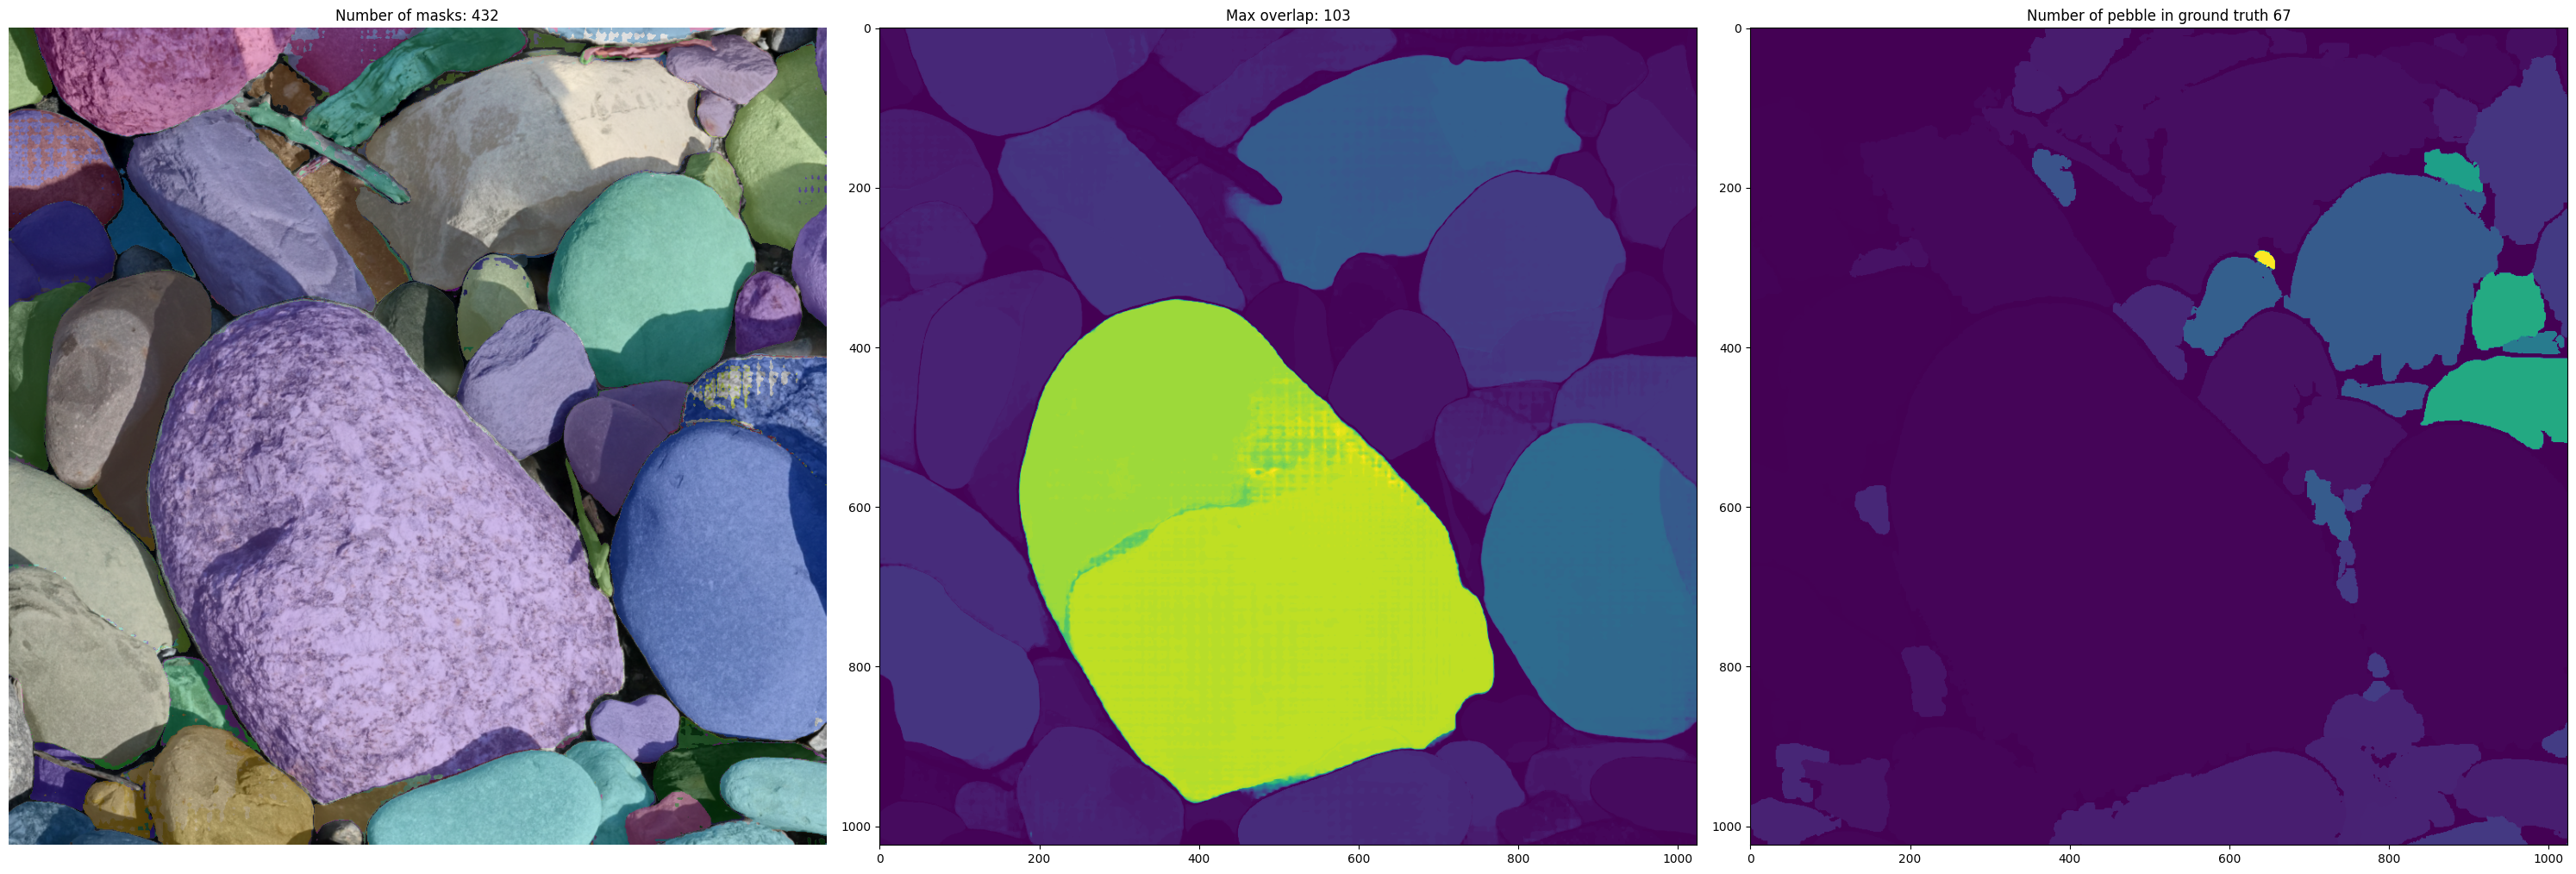

In [6]:
fig, ax = plt.subplots(1,3,figsize=(30,20))
ax=ax.flatten()
i=0
ax[i*2].imshow(temp_image)
fnc.show_anns_mod_ax(masks, ax[i*2], label=None, sort=False)
ax[i*2].set_title(f'Number of masks: {len(masks)}')
ax[i*2].axis('off')
list_of_masks = [mask['segmentation'].astype(np.uint8) for mask in masks]
ar_masks=np.stack(list_of_masks) 
ax[i*2+1].imshow(np.sum(ar_masks,axis=0))
ax[i*2+1].set_title(f'Max overlap: {np.unique(np.sum(ar_masks,axis=0)).max()}')  
ax[2].imshow(temp_seg_id)  
ax[2].set_title(f'Number of pebble in ground truth {len(np.unique(temp_seg_id))}')   
plt.tight_layout()
plt.show()

In [105]:
bboxes = torch.tensor([mask['bbox'] for mask in masks], device=DEVICE, dtype=torch.float)
scores = torch.tensor([mask['predicted_iou'] for mask in masks], device=DEVICE, dtype=torch.float)
labels = torch.zeros_like(torch.tensor([mask['bbox'] for mask in masks], device=DEVICE)[:, 0])#torch.tensor(np.ones(len(masks)), device=DEVICE, dtype=torch.int)

keep = batched_nms(bboxes, scores, labels, 0.3)
masks=[masks[i] for i in keep]
len(masks)

284

In [106]:
seg_labels=(np.unique(temp_seg_id)[1:])

seg_size=[]
for seg in seg_labels:
    seg_size.append(np.sum(temp_seg_id==seg))

seg_size_sort_idx=np.argsort(seg_size)

In [108]:
list_of_label=[(temp_seg_id==seg_labels[index]).astype(np.uint8) for index in seg_size_sort_idx]
list_of_label_centroid = [fnc.get_centroid(mask) for mask in list_of_label]
ar_label=np.stack(list_of_label)

In [109]:
list_of_masks = [fnc.clean_mask(mask['segmentation'].astype(np.uint8)) for mask in masks]#remove small disconnected parts
list_of_mask_centroid = [fnc.get_centroid(mask) for mask in list_of_masks]
ar_masks=np.stack(list_of_masks)

In [110]:
ar_all=np.stack(list_of_label+list_of_masks)
list_of_centroid = [fnc.get_centroid(ar_all[i]) for i in range(len(ar_all))]
ar_all.shape

(350, 1024, 1024)

In [111]:
from sklearn.neighbors import KDTree
tree = KDTree(list_of_centroid)              
k=4
_, ind = tree.query(list_of_centroid[:len(list_of_label)], k=k)

# get nearest centroid iou
kdc_iou=[]
nearest_mask_pick=[]
for match in ind:
    #check if nearest neighbor is not a label
    j=1
    while match[j]<len(list_of_label):
        j+=1
    if j<k:
        kdc_iou.append(fnc.iou(ar_all[match[0]],ar_all[match[j]]))
        nearest_mask_pick.append(match[j])
    else:
        kdc_iou.append(-0.1)

In [112]:
ar_all_flat=ar_all.reshape((ar_all.shape[0],ar_all.shape[1]*ar_all.shape[2]))
set_overlap = set()

# Iterate through each column of the array
for i in range(ar_all_flat.shape[1]):
    # for each pixel find out the idex of mask where the pixel was in a mask
    nz = np.where(ar_all_flat[:, i] != 0)[0]
    
    # if there are overlap of mask
    if len(nz) > 1:
        nz_tuple = tuple(nz)
        set_overlap.add(nz_tuple)

# Convert the set back to a list if needed
list_overlap = list(set_overlap)

In [113]:
# get all average and max iou
overlap_by_label=[]
mask_label_inter=[]
max_iou=[]
avg_iou=[]
max_mask_pick=[]
for i in range(len(list_of_label)):
    all_pairs=[tup for tup in list_overlap if i in tup]
    if len(all_pairs)>0:
        overlap_with_i=np.unique(np.hstack(all_pairs))[1:]
        overlap_by_label.append(overlap_with_i)
        agg_iou=[]
        agg_inter=[]
        for j in overlap_with_i:
            agg_iou.append(fnc.iou(ar_label[i],ar_masks[j-len(list_of_label)]))
            agg_inter.append(np.logical_and(ar_label[i], ar_masks[j-len(list_of_label)]).sum())
        mask_label_inter.append(agg_inter)
        avg_iou.append(np.mean(agg_iou))
        max_iou.append(np.max(agg_iou))
        max_mask_pick.append(overlap_with_i[np.argmax(agg_iou)])
    else:
        overlap_by_label.append(np.array([]))
        mask_label_inter.append(np.array([]))
        avg_iou.append(-0.1)
        max_iou.append(-0.1)

In [114]:
nearest_subset_masks=[masks[i-len(list_of_label)] for i in nearest_mask_pick]
max_subset_masks=[masks[i-len(list_of_label)] for i in max_mask_pick]

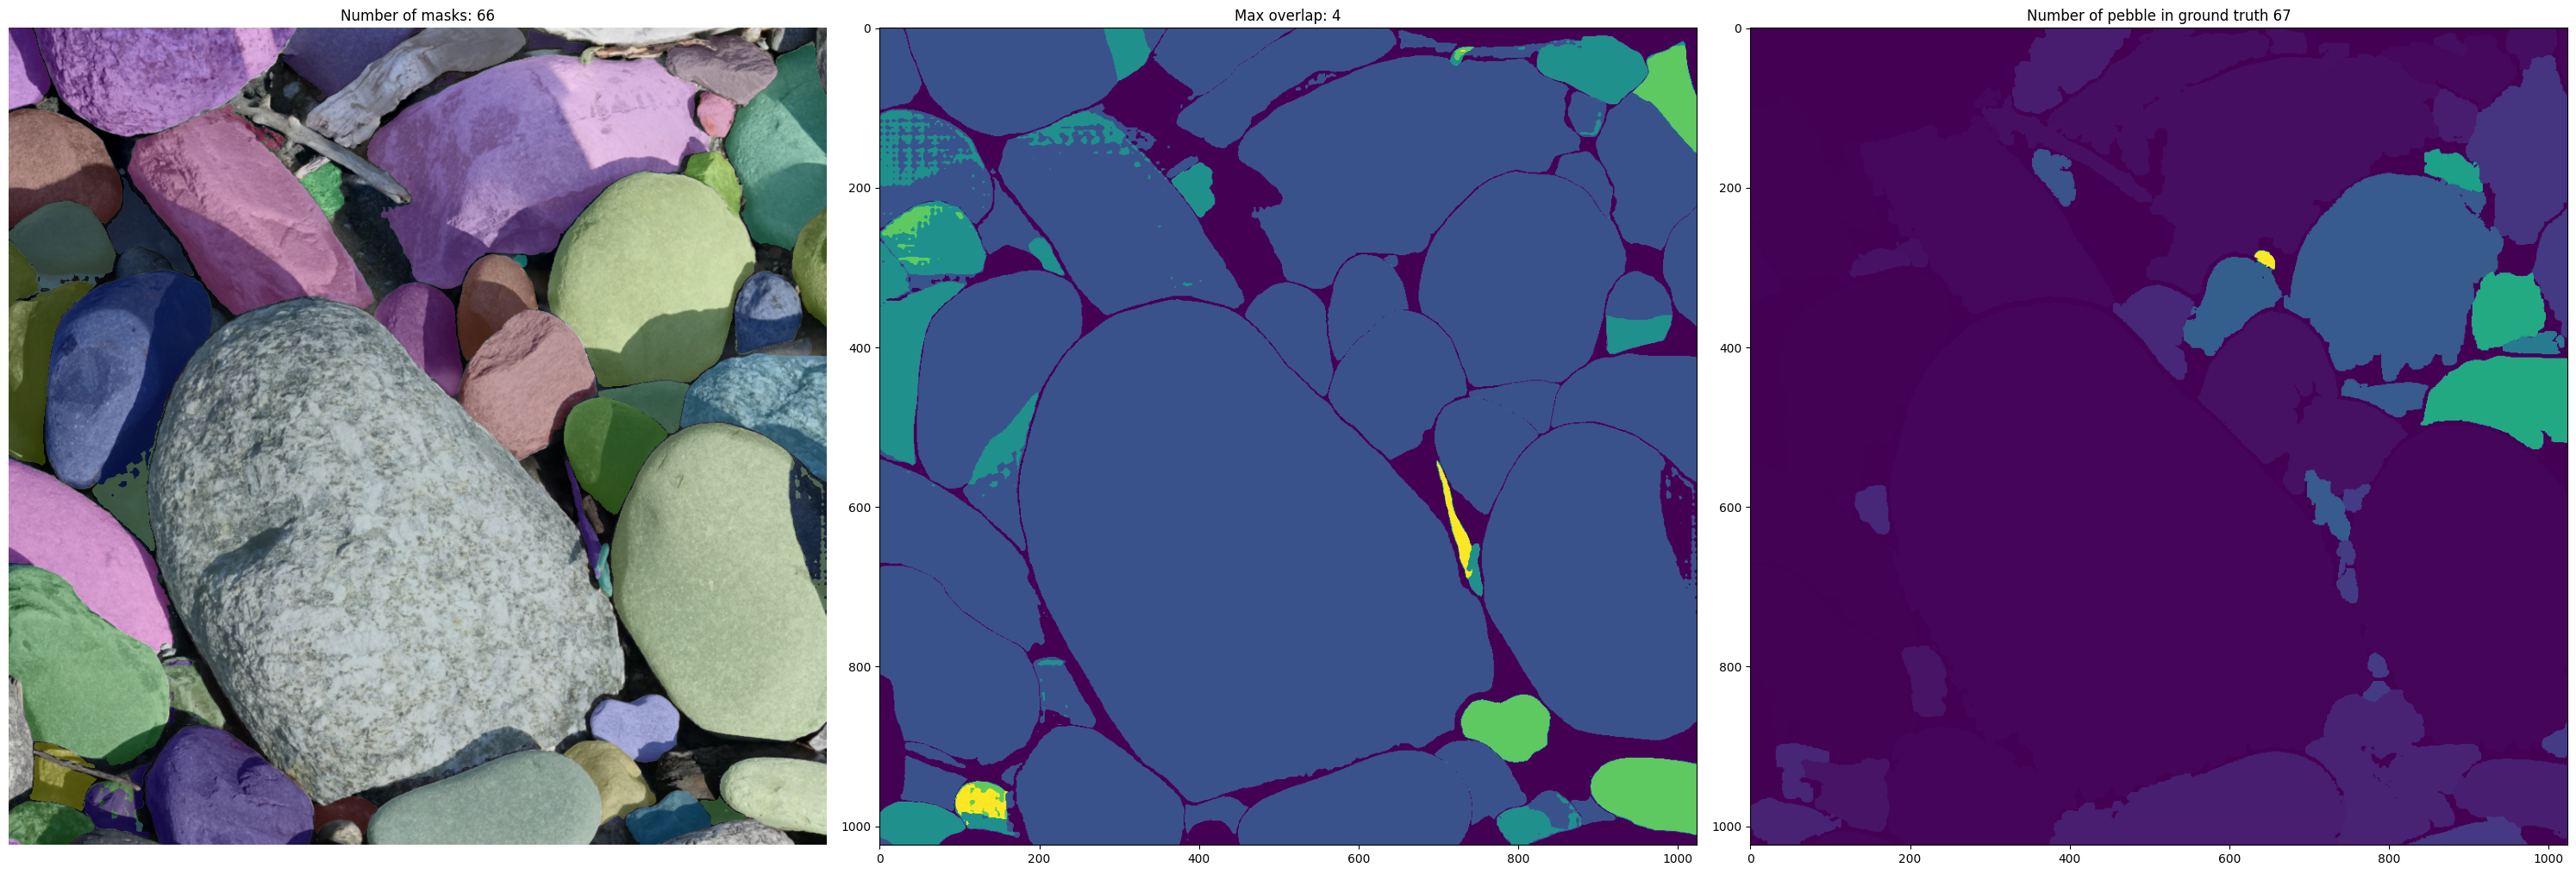

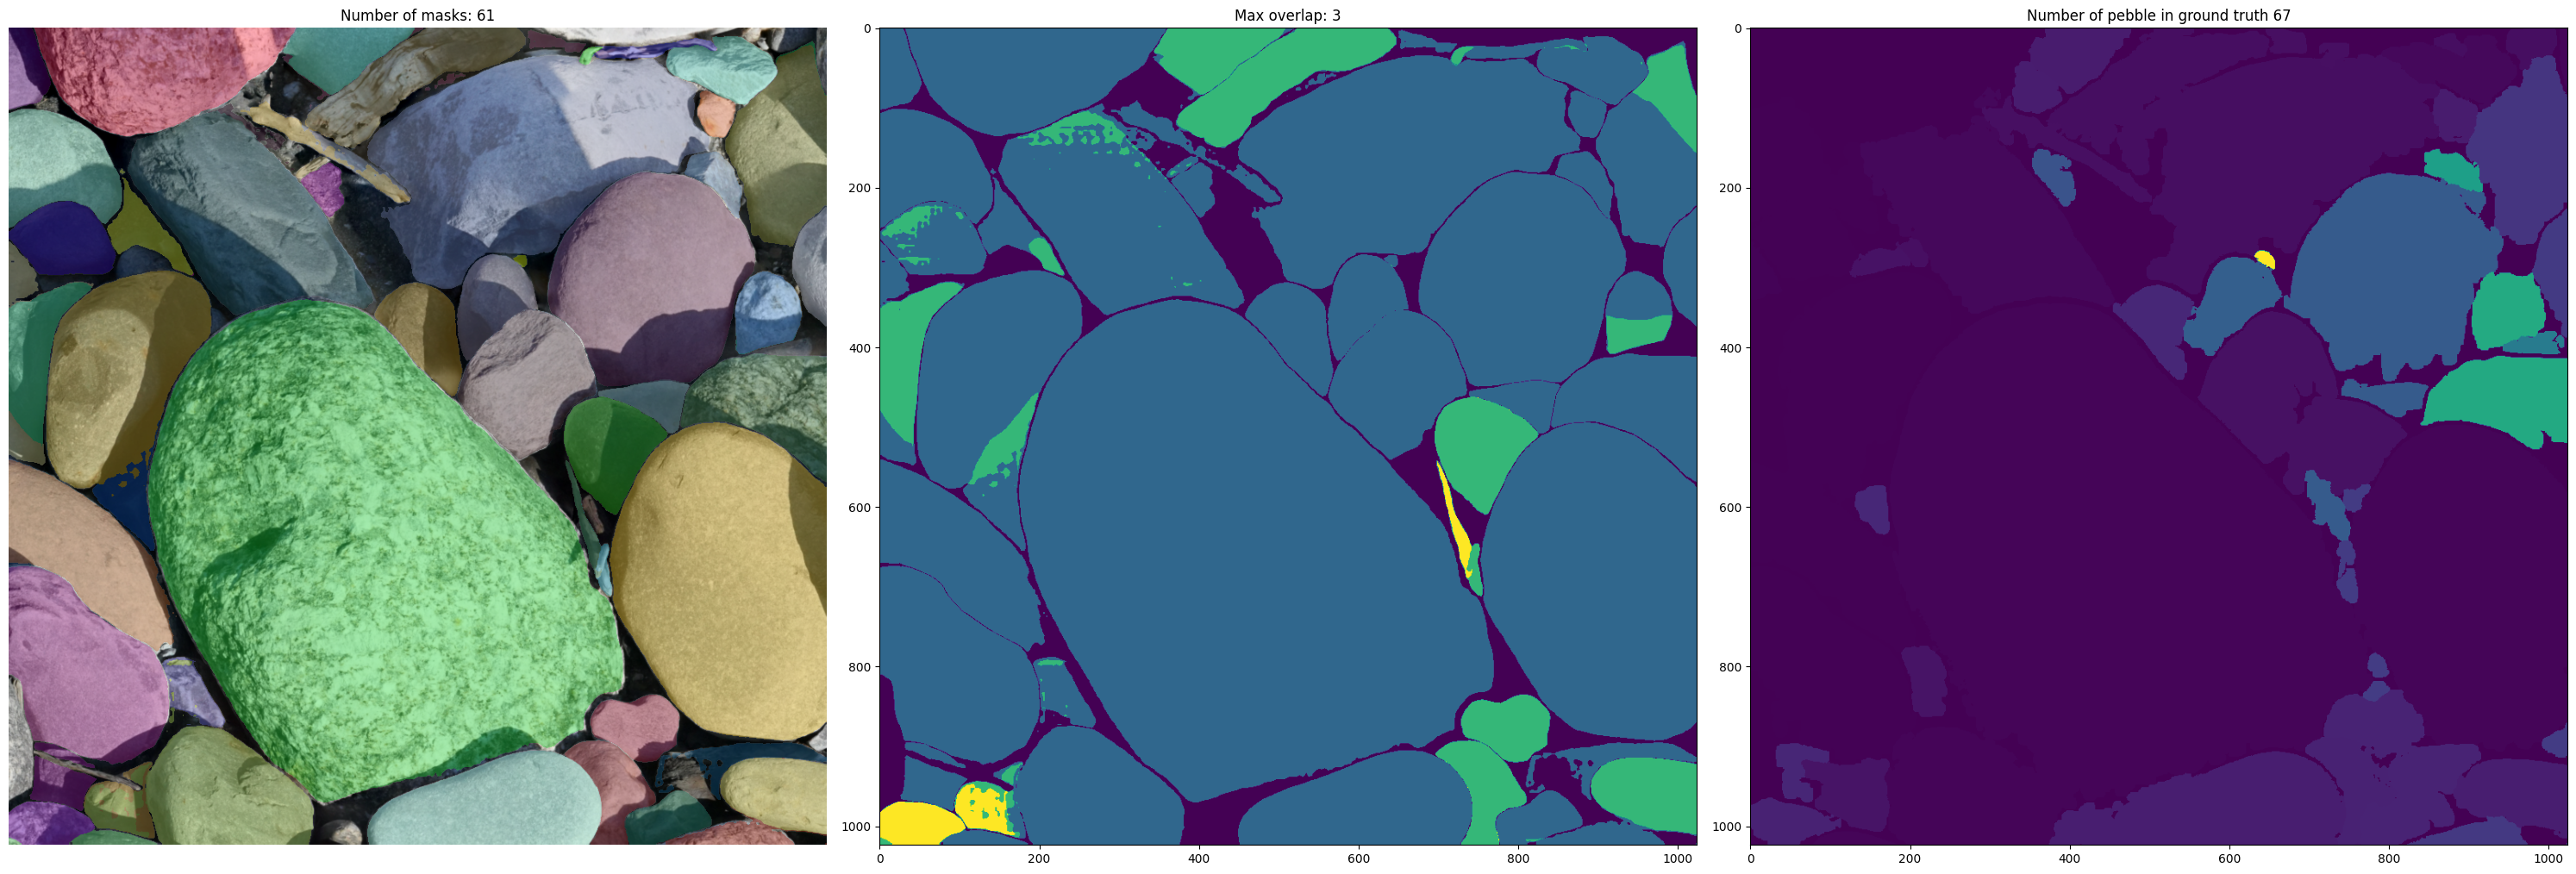

In [115]:
for t_masks in [nearest_subset_masks,max_subset_masks]:
    fig, ax = plt.subplots(1,3,figsize=(30,20))
    ax=ax.flatten()
    i=0
    ax[i*2].imshow(temp_image)
    fnc.show_anns_mod_ax(t_masks, ax[i*2], label=None, sort=False)
    ax[i*2].set_title(f'Number of masks: {len(t_masks)}')
    ax[i*2].axis('off')
    list_of_masks = [mask['segmentation'].astype(np.uint8) for mask in t_masks]
    ar_masks=np.stack(list_of_masks) 
    ax[i*2+1].imshow(np.sum(ar_masks,axis=0))
    ax[i*2+1].set_title(f'Max overlap: {np.unique(np.sum(ar_masks,axis=0)).max()}')  
    ax[2].imshow(temp_seg_id)  
    ax[2].set_title(f'Number of pebble in ground truth {len(np.unique(temp_seg_id))}')   
    plt.tight_layout()
    plt.show()

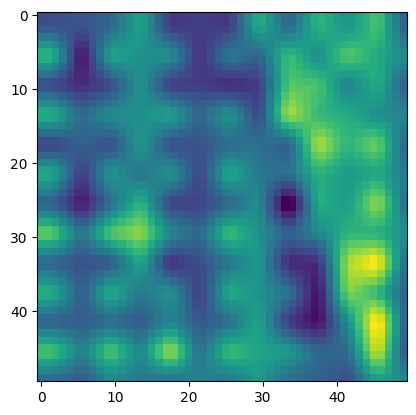

In [138]:
plt.imshow(masks[0]['p_mask'][:50,:50])

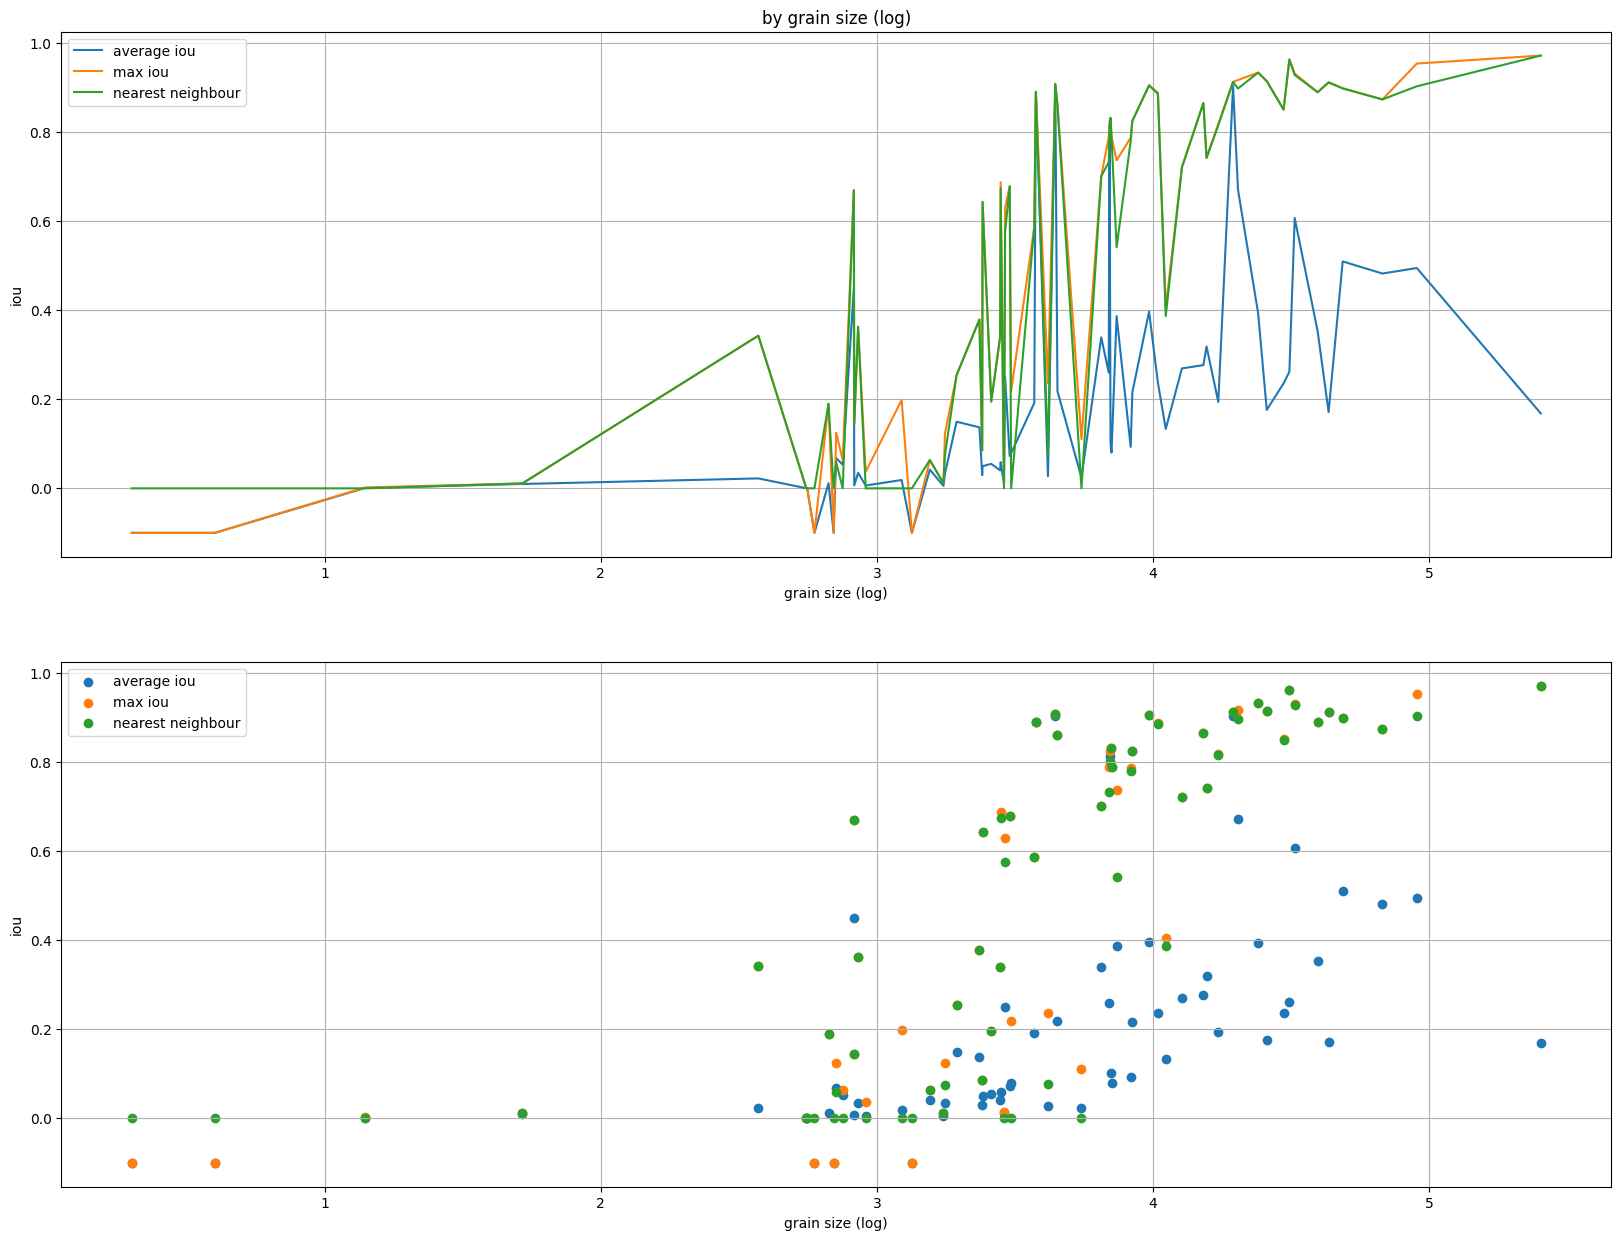

In [116]:
fig,ax=plt.subplots(2,1,figsize=(20,15))
ax=ax.flatten()
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),avg_iou,label='average iou')
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),max_iou,label='max iou')
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),kdc_iou,label='nearest neighbour')
ax[0].set_xlabel('grain size (log)')
ax[0].set_ylabel('iou')
ax[0].grid()
ax[0].legend()
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),avg_iou,label='average iou')
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),max_iou,label='max iou')
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),kdc_iou,label='nearest neighbour')
ax[1].set_xlabel('grain size (log)')
ax[1].set_ylabel('iou')
ax[1].grid()
ax[1].legend()
ax[0].set_title('by grain size (log)')
plt.show()

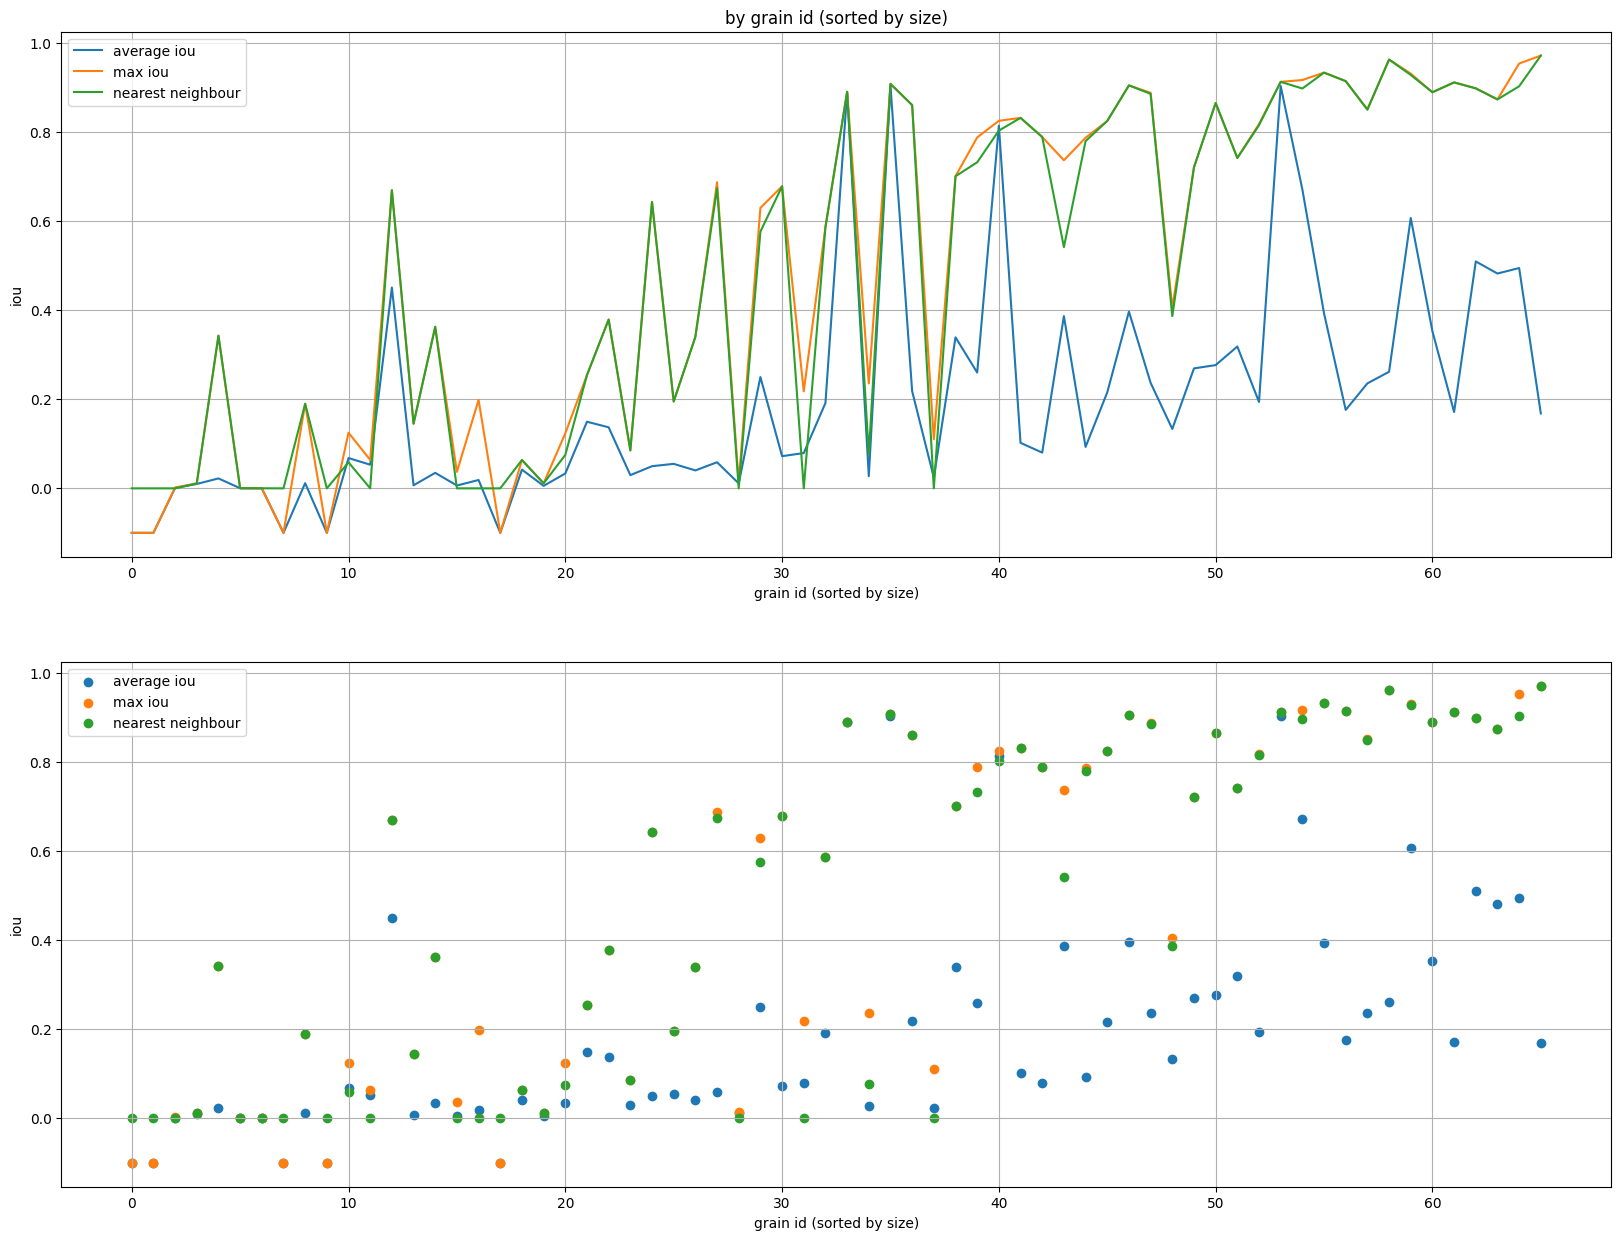

In [117]:
fig,ax=plt.subplots(2,1,figsize=(20,15))
ax=ax.flatten()
ax[0].plot(range(len(list_of_label)),avg_iou,label='average iou')
ax[0].plot(range(len(list_of_label)),max_iou,label='max iou')
ax[0].plot(range(len(list_of_label)),kdc_iou,label='nearest neighbour')
ax[0].set_xlabel('grain id (sorted by size)')
ax[0].set_ylabel('iou')
ax[0].grid()
ax[0].legend()
ax[1].scatter(range(len(list_of_label)),avg_iou,label='average iou')
ax[1].scatter(range(len(list_of_label)),max_iou,label='max iou')
ax[1].scatter(range(len(list_of_label)),kdc_iou,label='nearest neighbour')
ax[1].set_xlabel('grain id (sorted by size)')
ax[1].set_ylabel('iou')
ax[1].grid()
ax[1].legend()
ax[0].set_title('by grain id (sorted by size)')
plt.show()

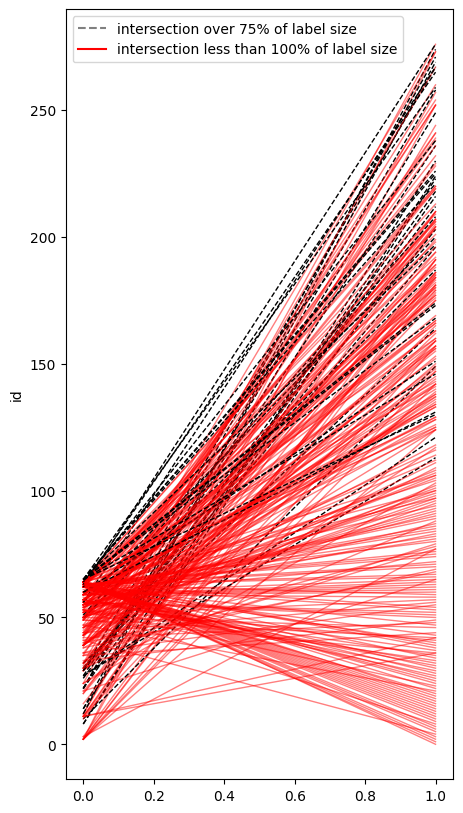

In [130]:
from matplotlib.lines import Line2D
num_label=len(ar_label)
plt.figure(figsize=(5, 10))
for j in range(num_label):
    ground_truth_area=np.sum(ar_label[j])
    for i,id in enumerate(overlap_by_label[j]):
        inter_perc=mask_label_inter[j][i]/ground_truth_area
        if inter_perc<0.25:
            ls,lw,k='--',1,'gray'
        elif inter_perc<0.5:
            ls,lw,k='-',1,'gray'
        elif inter_perc<0.75:
            ls,lw,k='--',1,'k'
            plt.plot([0,1],[j,id-num_label],ls, linewidth=lw, color=k)
        else:
            ls,lw,k='-',1,'r'
            plt.plot([0,1],[j,id-num_label],ls, linewidth=lw, color=k,alpha=0.5)
handles, labels = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='intersection over 75% of label size',linestyle='--', color='gray')
line2 = Line2D([0], [0], label='intersection less than 100% of label size', color='r')
handles.extend([line, line2])
plt.legend(handles=handles)
plt.ylabel('id')
plt.show()

In [19]:
i=2
all_pairs=[tup for tup in list_overlap if i in tup]
print(np.unique(np.hstack(all_pairs))[1:])
for j in np.unique(np.hstack(all_pairs))[1:]:
    print(fnc.iou(ar_label[i],ar_masks[j-len(list_of_label)]))

[190 208 213 223 247 250 318 339]
0.0004234596654668643
0.0004243710215216732
0.0019191226867717615
0.0004224884570117995
0.00042529922838568566
0.0004229862831591033
0.0009993575558569492
0.001892403352257367


In [22]:
#manual stability score
p1=(masks[16]['p_mask']/logit_scale)>1
n1=(masks[16]['p_mask']/logit_scale)>-1
fnc.iou(p1,n1)

0.9843097511538743

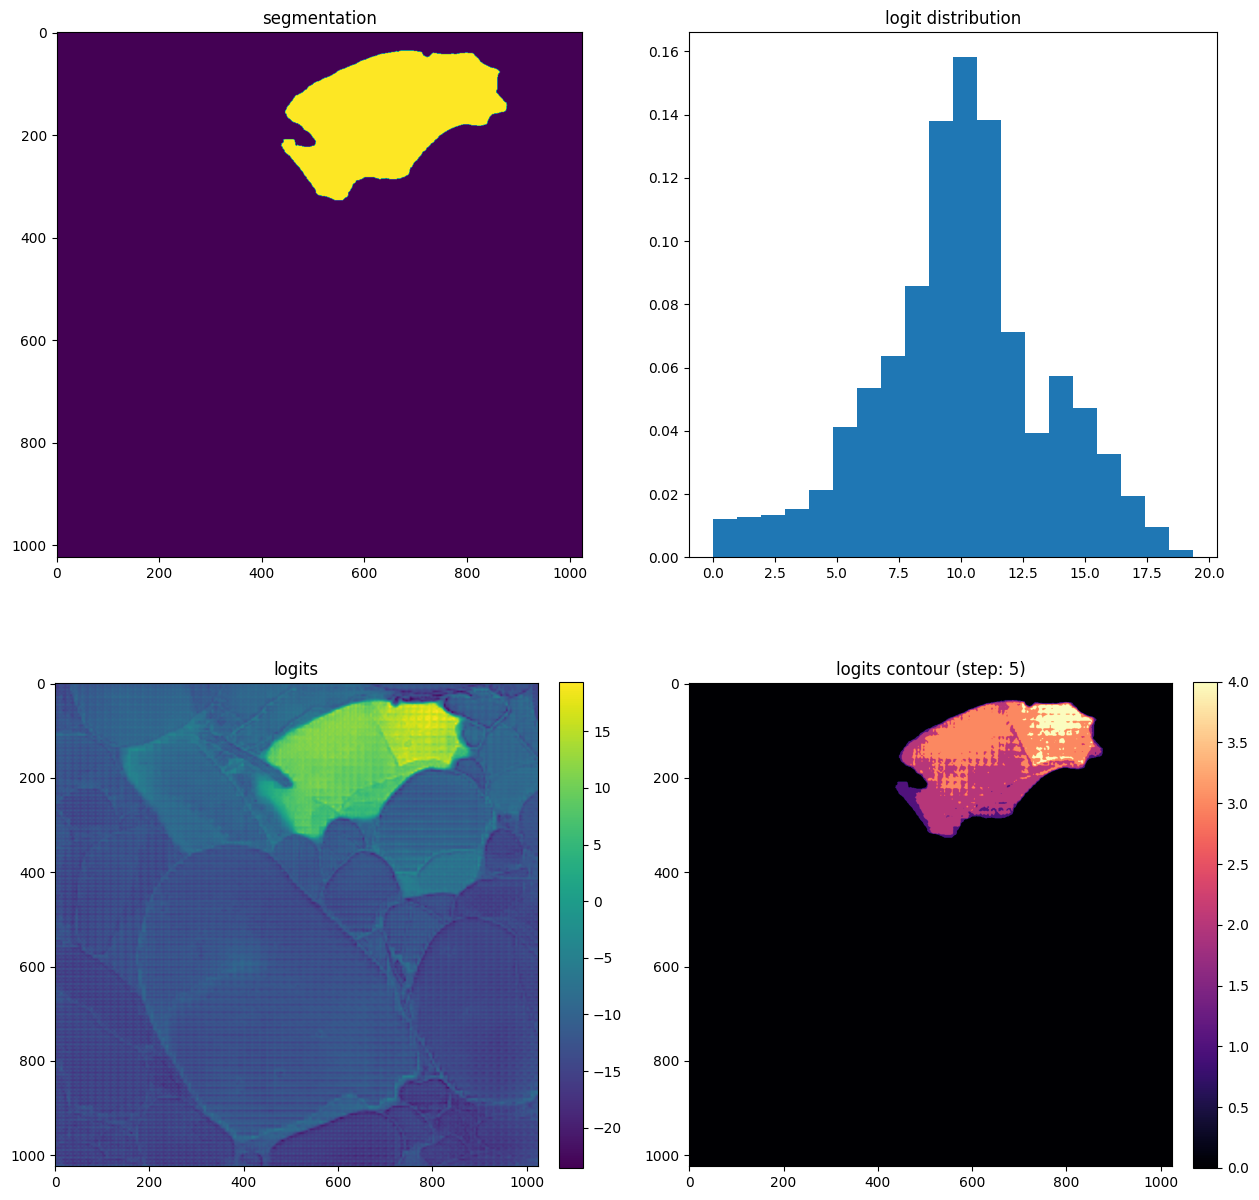

In [24]:
mi=30
logit_mask=(masks[mi]['p_mask']/logit_scale)

logit_step=5
contour_logit=(logit_mask>0).astype(int)
for i in np.arange(logit_step, logit_mask.max(),logit_step):
    contour_logit+=(logit_mask>i).astype(int)

#temp=logit_mask.copy()
#temp[temp<0]=0
#levels = np.arange(-1.0, int(logit_mask.max()), logit_step)

fig, ax=plt.subplots(2,2,figsize=(15,15))
ax=ax.flatten()
ax[0].imshow(masks[mi]['segmentation'])
ax[0].set_title('segmentation')

ax[1].hist(logit_mask[logit_mask>0].flatten(), density=True, bins=20)
ax[1].set_title('logit distribution')

im=ax[2].imshow((masks[mi]['p_mask']/logit_scale))
ax[2].set_title('logits')
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

im2=ax[3].imshow(contour_logit, cmap='magma')
#im2 = ax[2].imshow(temp, cmap='magma', interpolation='none')
#contours = ax[2].contour(temp, levels)#, colors='white')
#ax[2].clabel(contours, inline=True, fontsize=8)

ax[3].set_title(f'logits contour (step: {logit_step})')
plt.colorbar(im2,ax=ax[3], fraction=0.046, pad=0.04)

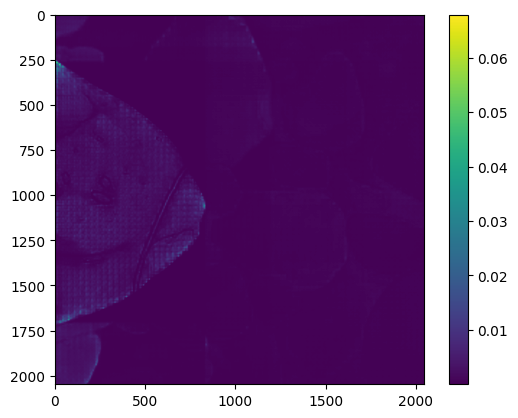

In [7]:
#test logit to probability
from scipy.special import softmax

probabilities = softmax(masks[mi]['p_mask']/logit_scale, axis=1)+softmax(masks[mi]['p_mask']/logit_scale, axis=0)
plt.imshow(probabilities)
plt.colorbar()

In [31]:
#nms remove overlap
nms_threshold=0.3

#sort by iou
iou_lst=[mask['predicted_iou'] for mask in masks]
iou_ar=np.array(iou_lst)
#sort_score_idx=np.argsort(iou_lst)#sort by score from low to high

#find overlaps
list_of_masks = [fnc.clean_mask(mask['segmentation'].astype(np.uint8)) for mask in masks]#remove small disconnected parts
ar_masks=np.stack(list_of_masks)
ar_masks_flat=ar_masks.reshape((ar_masks.shape[0],ar_masks.shape[1]*ar_masks.shape[2]))#flat 2d to 1d masks

list_overlap=[]
# Iterate through each column of the array
for i in range(ar_masks_flat.shape[1]):
    # for each pixel find out the idex of mask where the pixel was in a mask
    nz = np.where(ar_masks_flat[:, i] != 0)[0]
    
    # if there are overlap of mask
    if len(nz) > 1:
        list_overlap.append(tuple(nz))

#get uniqe pairs and intersection area(pixel) for each pair
group_counter=Counter(list_overlap)
unique_groups = [list(tup) for tup in group_counter.keys()]
group_overlap_area = list(group_counter.values())

#filter by intersection area
threshold=1000
filtered=np.array(group_overlap_area)>threshold
unique_groups_thresholded=[unique_groups[i] for i in range(len(unique_groups)) if filtered[i]]

#report filter
print(f'Threshold: {threshold} pixels, {len(list_overlap)-len(unique_groups_thresholded)} groups removed',
      f'\nOverlap groups before filtering: {len(list_overlap)}, after filtering: {len(unique_groups_thresholded)}')

Threshold: 1000 pixels, 3654603 groups removed 
Overlap groups before filtering: 3654674, after filtering: 71


In [85]:
nms_threshold=0.3
dump_all=[]
template_empty=np.zeros(masks[0]['segmentation'].shape)

bbox_masks = []
for mask in masks:
    box = mask['bbox']
    bbox_mask = template_empty.copy()
    bbox_mask[box[0]:box[3], box[1]:box[2]] = 1
    bbox_masks.append(bbox_mask)

for group in unique_groups_thresholded:

    #get iou of each mask in the group
    group_score_lst=iou_ar[np.array(group)]
    #sort from low to high by iou
    sorted_score_idx=np.argsort(group_score_lst)

    #group_nms=[]
    dump=[]

    #check for each mask in the layer
    for i in range(len(group)):
        idx_i = group[sorted_score_idx[i]]
        if idx_i not in dump:
            #get mask i bbox for iou
            bbox_i_mask = bbox_masks[idx_i]

            i_valid=True
            for j in range(i + 1, len(group)):
                
                #get mask j bbox for iou
                idx_j = group[sorted_score_idx[j]]
                bbox_j_mask = bbox_masks[idx_j]
                

                box_iou_of_ij=iou(bbox_i_mask,bbox_j_mask)
                #the iou is larger than threshold so they are seen as same object
                if box_iou_of_ij>nms_threshold:
                    dump.append(group[sorted_score_idx[i]])
                    i_valid=False
                    break
            #if i_valid:
                #group_nms.append(group[sorted_score_idx[i]])
    dump_all.append(dump)


In [52]:
nms_threshold=0.8
group = unique_groups_thresholded[1]
#get iou of each mask in the group
group_score_lst=iou_ar[np.array(group)]
#sort from low to high by iou
sorted_score_idx=np.argsort(group_score_lst)

group_nms=[]
dump=[]
template_empty=np.zeros(masks[0]['segmentation'].shape)

#check for each mask in the layer
for i in range(len(group)):
    if group[sorted_score_idx[i]] not in dump:
        #get mask i bbox for iou
        box_i=masks[group[sorted_score_idx[i]]]['bbox']
        bbox_i_mask=template_empty.copy()
        bbox_i_mask[box_i[0]:box_i[3],box_i[1]:box_i[2]]=1

        j=i+1
        i_valid=True

        for j in range(i + 1, len(group)):
            
            #get mask j bbox for iou
            box_j=masks[group[sorted_score_idx[j]]]['bbox']
            bbox_j_mask=template_empty.copy()
            bbox_j_mask[box_j[0]:box_j[3],box_j[1]:box_j[2]]=1
            

            box_iou_of_ij=iou(bbox_i_mask,bbox_j_mask)
            j+=1
            #the iou is larger than threshold so they are seen as same object
            if box_iou_of_ij>nms_threshold:
                dump.append(group[sorted_score_idx[i]])
                i_valid=False
                break
        if i_valid:
            group_nms.append(group[sorted_score_idx[i]])


In [86]:
delete_list=np.unique(np.hstack(dump_all))
remaining=np.array([i for i in range(len(masks)) if i not in delete_list])

In [57]:
bboxes = torch.tensor([mask['bbox'] for mask in masks], device=DEVICE, dtype=torch.float)
scores = torch.tensor([mask['predicted_iou'] for mask in masks], device=DEVICE, dtype=torch.float)
labels = torch.tensor(np.ones(len(masks)), device=DEVICE, dtype=torch.int)

keep = batched_nms(bboxes, scores, labels, 0.3)
masks_nms=[masks[i] for i in keep]

In [87]:
remaining

array([  0,   2,  14,  16,  18,  19,  34,  35,  36,  38,  55,  56,  57,
        58,  59,  60,  61,  62,  73,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 113, 114, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 142, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 169, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262])

In [88]:
np.sort(keep.cpu())

array([  0,   2,  14,  16,  18,  19,  34,  35,  36,  38,  55,  56,  57,
        58,  59,  60,  61,  62,  73,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 113, 114, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 142, 146, 147, 148, 149, 151, 153,
       154, 155, 156, 157, 158, 159, 160, 169, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262])

In [89]:
np.setdiff1d(remaining, np.sort(keep.cpu()), assume_unique=True).tolist()

[150, 152]

In [90]:
np.setdiff1d(np.sort(keep.cpu()), remaining, assume_unique=True).tolist()

[]